In [500]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as sio
from sklearn.svm import SVC
import random as rnd
%matplotlib inline

In [556]:
data = sio.loadmat('HW2_Data/data1.mat')
Xtrn = data['X_trn']
Ytrn = np.asmatrix(data['Y_trn'], dtype = np.int32)
Xtest = data['X_tst']
Ytest = np.asmatrix(data['Y_tst'], dtype = np.int32)

for i in range(Ytrn.shape[0]):
    if(Ytrn[i] == 0): Ytrn[i] = -1;
for i in range(Ytest.shape[0]):
    if(Ytest[i] == 0): Ytest[i] = -1;


In [502]:
def computeError(Y, Ysvm):
    Ysvm = np.sign(Ysvm);
    count = 0
    for i in range(Y.shape[0]):
        if (Y[i, 0] != Ysvm[i,0]): count+= 1;
    return count/Ysvm.shape[0]

In [503]:
def mySvm(X, w, b):
    op=[]
    for i in range(X.shape[0]):
        ops = np.dot(X[i, :], w.T) + b
        op.append(ops)
    return op

In [504]:
def plotOnTest(xLabel, yLabel, f, X_tst):

    fig, ax = plt.subplots(figsize=(12,8))
    ax.plot(x, f, 'r', label='Prediction')
    ax.scatter(X_tst[0:7,0], X_tst[0:7,1], label='-1')
    ax.scatter(X_tst[8:X_tst.shape[0],0], X_tst[8:X_tst.shape[0],1], label='1')
    ax.legend(loc=2)
    ax.set_xlabel(xLabel)
    ax.set_ylabel(yLabel)
    ax.set_title('x1 vs x2')

In [505]:
def plotPrediction(xLabel, yLabel, f, X_trn, classChange):

    fig, ax = plt.subplots(figsize=(12,8))
    ax.plot(x, f, 'r', label='Prediction')
    ax.scatter(X_trn[0:classChange,0], X_trn[0:classChange,1], label='-1')
    ax.scatter(X_trn[classChange+1:X_trn.shape[0],0], X_trn[classChange+1:X_trn.shape[0],1], label='1')
    ax.legend(loc=2)
    ax.set_xlabel(xLabel)
    ax.set_ylabel(yLabel)
    ax.set_title('x1 vs x2')

# Simplified SMO

In [506]:
def simplifiedSMO(regParam, maxPasses, Xtrn, Ytrn, tol): 
    alpha = np.zeros(Ytrn.shape, dtype=np.int)
    prevAlpha = np.zeros(Ytrn.shape, dtype=np.int)
    b = 0
    passes = 0
    while passes < maxPasses:
        modifiedCount = 0
        print(passes)
        for i in range(Ytrn.shape[0]):
            fi = computeClassifier(Xtrn[i], b, alpha)
            Ei = fi - Ytrn[i]
            if(Ytrn[i]*Ei < -tol and alpha[i] < regParam) or (Ytrn[i]*Ei > tol and alpha[i] > 0):
                while True:
                    j = rnd.sample(range(0,Ytrn.shape[0]-1), 1)[0]
                    
                    if (i != j): break;
                fj = computeClassifier(Xtrn[j], b, alpha)
                Ej = fj - Ytrn[j]
                prevAlpha[i] = alpha[i]
                prevAlpha[j] = alpha[j]
                
                L, H = calculateLH(Ytrn[i], Ytrn[j], regParam, alpha[j], alpha[i])
                if(L == H): continue;
                
                eta = calculateEta(Xtrn[i], Xtrn[j].T);
                if(eta >= 0): continue;
                
                alpha[j] = computeAndClip(alpha[j], Ytrn[j], Ei, Ej, eta)
                if(alpha[j] > H): alpha[j] = H;
                if(alpha[j] < L): alpha[j] = L;
                      
                if(abs(alpha[j] - prevAlpha[j]) < 10**-5): continue;
                
                alpha[i] = determineAlpha(alpha[i], Ytrn[i], Ytrn[j], prevAlpha[j], alpha[j]);
                
                b1 = b - Ei - determineB1(Ytrn[i], Ytrn[j], alpha[i], alpha[j], prevAlpha[i], prevAlpha[j], Xtrn[i], Xtrn[j]);
                b2 = b - Ej - determineB2(Ytrn[i], Ytrn[j], alpha[i], alpha[j], prevAlpha[i], prevAlpha[j], Xtrn[i], Xtrn[j]); 
               
                if(alpha[i] < regParam and alpha[i] > 0): b=b1;
                elif(alpha[j] < regParam and alpha[j] > 0): b=b2;
                else: b = (b1+b2)/2;
                
                modifiedCount += 1;
        if(modifiedCount == 0): passes += 1;
        else: passes = 0;
            
    return alpha, b, modifiedCount
                                   
                



# Helpers

In [507]:
def determineB1(yTrnI, yTrnJ, alphaI, alphaJ, prevAlphaI, prevAlphaJ, xTrnI, xTrnJ):
    prod1 = yTrnI * (alphaI - prevAlphaI) * kernel(xTrnI, xTrnI, 1)
    prod2 = yTrnJ * (alphaJ - prevAlphaJ) * kernel(xTrnJ, xTrnI, 1)
    return prod1 + prod2

def determineB2(yTrnI, yTrnJ, alphaI, alphaJ, prevAlphaI, prevAlphaJ, xTrnI, xTrnJ):
    prod1 = yTrnI * (alphaI - prevAlphaI) * kernel(xTrnJ, xTrnI, 1)
    prod2 = yTrnJ * (alphaJ - prevAlphaJ) * kernel(xTrnJ, xTrnJ.T, 1)
    return prod1 + prod2

def computeAndClip(alpha, Ytrn, Ei, Ej, eta):
    change = (Ytrn*(Ei - Ej)) / eta;
    return alpha - change;

def calculateEta(Xi, Xj):
    temp = 2*kernel(Xi, Xj, 1)
    temp -= kernel(Xi, Xi, 1)
    return temp - kernel(Xj.T, Xj, 1)

def computeClassifier(Xj, b, alpha):
    sum = 0
    for i in range(Ytrn.shape[0]):
        dotProd = kernel(Xtrn[i], Xj, 1)
        sum = sum + (alpha[i] * Ytrn[i] * dotProd)
    sum += b
    return sum

def kernel(X, Z, maxDegree): 
    prod = np.dot(X, Z)
    return prod**maxDegree

def calculateLH(yI, yJ, regParam, alphaJ, alphaI):
    if (yI != yJ): 
        l = max(0, alphaJ - alphaI);
        h = min(regParam, regParam + alphaJ - alphaI);
    else: 
        l = max(0, alphaJ + alphaI - regParam);
        h = min(regParam, alphaJ + alphaI);
    return l, h

def determineAlpha(alphaI, yTrnI, yTrnJ, prevAlphaJ, alphaJ):
    prod = yTrnI*yTrnJ;
    prod = prod * (prevAlphaJ - alphaJ);
    return alphaI + prod

In [508]:
alpha, b, count = simplifiedSMO(1, 20, Xtrn, Ytrn, 0.01);

0
0
0
0
1
2
3
0
1
2
3
4
0
0
1
0
0
1
2
0
1
0
1
0
0
0
1
2
3
0
1
0
0
1
0
1
0
1
2
3
4
5
0
1
0
1
2
3
0
1
2
3
4
0
1
0
0
1
2
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [509]:
weight = np.zeros((Xtrn.shape[1],1), dtype=np.float32).T
for i in range(Ytrn.shape[0]):
    weight += alpha[i] * Ytrn[i] * Xtrn[i]   
print("weights: ", weight, " b: ", b)
Ysvm = mySvm(Xtrn, weight, b)
Ysvm2 = mySvm(Xtest, weight, b)
print("Classification Error on training samples of dataset1: ", computeError(Ytrn, Ysvm))
print("Classification Error on test samples of dataset1: ", computeError(Ytest, Ysvm2))

weights:  [[ 1.74178934 -1.00122929]]  b:  [[ 1.77564844]]
Classification Error on training samples of dataset1:  0.023809523809523808
Classification Error on test samples of dataset1:  0.0


In [510]:
Ysvm2 = mySvm(Xtest, weight, b)

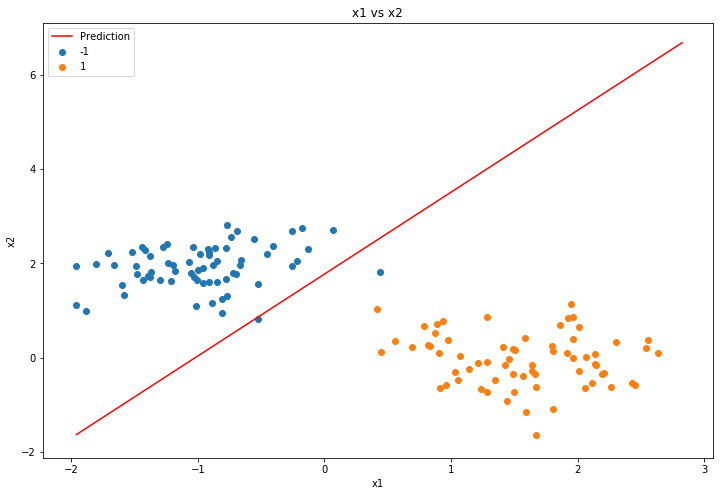

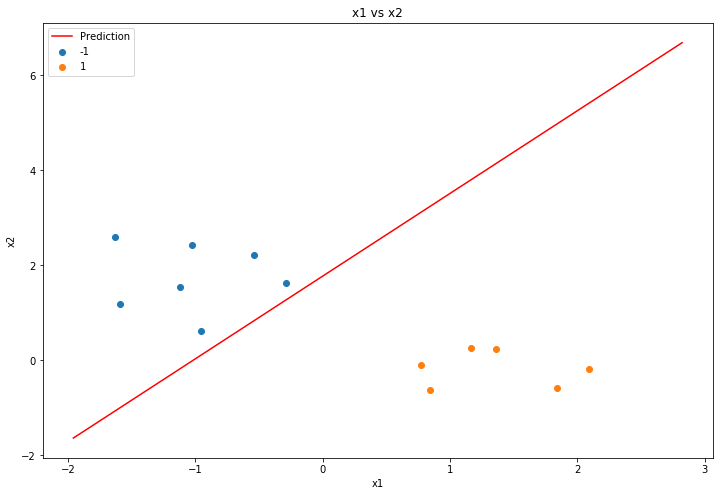

In [542]:
x = np.linspace(Xtrn.min(), Xtrn.max(), 100)
f = -(b[0,0] + (weight[0,0] * x))/weight[0,1] 
plotPrediction('x1', 'x2', f, data['X_trn'], 68)
plotOnTest('x1', 'x2', f, data['X_tst'])

In [560]:
svm = SVC(C=10, kernel="linear")
svm.fit(Xtrn, np.asarray(Ytrn))
Ysvm = mySvm(Xtrn, svm.coef_, svm.intercept_)
Ysvm2 = mySvm(Xtest, svm.coef_, svm.intercept_)
print("Classification Error on training samples of dataset1: ", computeError(Ytrn, Ysvm))
print("Classification Error on test samples of dataset1: ", computeError(Ytest, Ysvm2))
print()
print(svm.intercept_)

Classification Error on training samples of dataset1:  0.0
Classification Error on test samples of dataset1:  0.0

[ 2.61582226]


/Users/sidharththapar/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


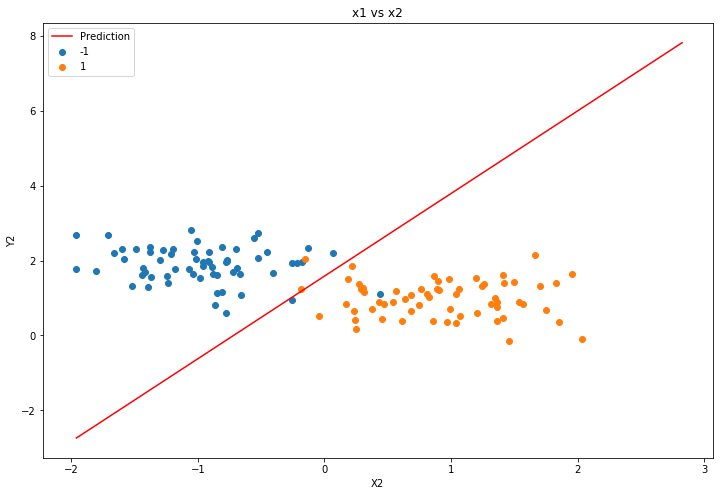

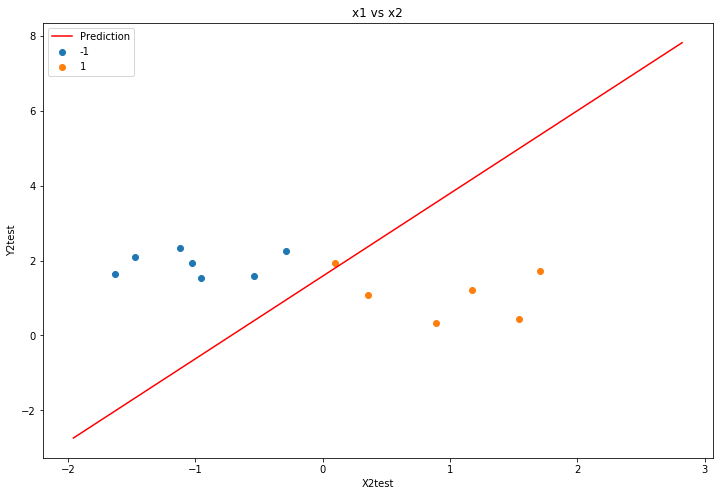

In [551]:
x = np.linspace(Xtrn.min(), Xtrn.max(), 100)
f = -(svm.intercept_[0] + (svm.coef_[0,0] * x))/svm.coef_[0,1] 

plotPrediction('X2', 'Y2', f, data['X_trn'], 63)
plotOnTest('X2test', 'Y2test', f, data['X_tst'])

# DataSet 2